In [1]:
import os
import torch
import numpy as np

import scanpy as sc
from anndata import AnnData
import anndata as ad

result_dir = "../edges/"
raw_type=False
use_edge=False

In [2]:
sample='Lung6'
data_dir = "../../data/NSCLC/processed1/"
str_position_x="CenterX_global_px"
str_position_y="CenterY_global_px"
str_cell_type="CellType"

In [3]:
genes = torch.load("/".join(data_dir.split("/")[:-2]) + "/genes.pth")
print(genes)
type_exp_dict=np.load(data_dir + sample + "_TypeExp.npz", allow_pickle=True)

['AATK', 'ABL1', 'ABL2', 'ACE', 'ACE2', 'ACKR1', 'ACKR3', 'ACKR4', 'ACTA2', 'ACTG2', 'ACVR1', 'ACVR1B', 'ACVR2A', 'ACVRL1', 'ADGRA2', 'ADGRA3', 'ADGRB2', 'ADGRB3', 'ADGRD1', 'ADGRE1', 'ADGRE2', 'ADGRE5', 'ADGRF1', 'ADGRF3', 'ADGRF4', 'ADGRF5', 'ADGRG1', 'ADGRG2', 'ADGRG3', 'ADGRG5', 'ADGRG6', 'ADGRL1', 'ADGRL2', 'ADGRL4', 'ADGRV1', 'ADIPOQ', 'ADIRF', 'ADM2', 'ADORA2A', 'AGR2', 'AHI1', 'AHR', 'AKT1', 'ALCAM', 'ANGPT1', 'ANGPT2', 'ANGPT4', 'ANGPTL1', 'ANXA1', 'ANXA2', 'ANXA4', 'APOA1', 'APOB', 'APOD', 'APP', 'AQP3', 'AR', 'AREG', 'ARF1', 'ARG1', 'ARHGDIB', 'ARTN', 'ATF3', 'ATG10', 'ATG12', 'ATG5', 'ATM', 'ATR', 'AXL', 'AZGP1', 'AZU1', 'B2M', 'B3GNT7', 'BAG3', 'BATF3', 'BAX', 'BCL2', 'BCL2L1', 'BECN1', 'BEST1', 'BGN', 'BID', 'BIRC5', 'BMP1', 'BMP2', 'BMP3', 'BMP4', 'BMP5', 'BMP6', 'BMP7', 'BMPR1A', 'BMPR2', 'BMX', 'BRCA1', 'BST1', 'BST2', 'BTG1', 'BTK', 'C11orf96', 'C1QA', 'C1QB', 'C1QC', 'C5AR2', 'C9orf16', 'CALB1', 'CALD1', 'CALM1', 'CALM2', 'CALM3', 'CAMP', 'CASP3', 'CASP8', 'CASR', 'C

In [4]:
def read_data(sample,select=10,loss_threshold=None,normalize=False):
    results=torch.load(result_dir+"edges_"+sample+".pth",map_location=torch.device('cpu'))
    edges=results["attention_score"]
    # modify here
    if normalize:
        attention_score=results["attention_score"]/torch.sum(torch.abs(results["attention_score"]),dim=-2,keepdim=True)
    else:
        attention_score=results["attention_score"]
        normalized_attention_score=results["attention_score"]/torch.sum(results["attention_score"],dim=-2,keepdim=True)
    print(attention_score.shape)
    position_x=results["position_x"]
    position_y=results["position_y"]
    cell_type_name=results["cell_type_name"]
    loss1=results["loss_all"].cpu()
    
    B,N=position_x.shape
    loss1=loss1.unsqueeze(dim=-1).repeat(1,select).reshape(-1).numpy()
    
    cell_type_target=[cell_type_name[i][0] for i in range(len(cell_type_name))]
    
    if normalize:
        indices=torch.topk(torch.sum(attention_score,dim=-1),k=select,dim=-1)[1]
        print(torch.topk(torch.mean(attention_score,dim=-1),k=select,dim=-1))
    else:
        tmp=torch.abs(torch.abs(results["attention_score"])/torch.sum(torch.abs(results["attention_score"]),dim=-2,keepdim=True))
        indices=torch.topk(torch.sum(tmp,dim=-1),k=select,dim=-1)[1]
        print(torch.topk(torch.mean(tmp,dim=-1),k=select,dim=-1))
    indices_tmp=torch.arange(0,indices.shape[0],1).unsqueeze(dim=-1).repeat(1,select)
    indices=torch.stack([indices_tmp.reshape(-1),indices.reshape(-1)],dim=0)

    if not use_edge:
        edges=attention_score
        print("not use edge",edges.shape)
    
    edges=edges[indices[0],indices[1],:].reshape(-1,edges.shape[-1]).numpy()
    attention_score=attention_score[indices[0],indices[1],:].reshape(-1,attention_score.shape[-1]).numpy()
    
    to_position_x=position_x[:,0:1].repeat(1,select).reshape(-1).numpy()
    to_position_y=position_y[:,0:1].repeat(1,select).reshape(-1).numpy()
    from_position_x=position_x[:,1:][indices[0],indices[1]].reshape(-1).numpy()
    from_position_y=position_y[:,1:][indices[0],indices[1]].reshape(-1).numpy()
    
    dx=position_x-position_x[:,0:1]
    dy=position_y-position_y[:,0:1]
    distances=torch.sqrt(torch.square(dx)+torch.square(dy))
    distances=distances[indices[0],indices[1]].reshape(-1).numpy()
    
    indices_np=indices.numpy()
    cell_types=np.array(cell_type_name)[:,1:][indices_np[0],indices_np[1]].reshape(B,select)
    print("number of cell types in this sample:",np.unique(np.array(cell_type_name)[:,0],return_counts=True))
    cell_types_pair=[]
    cell_types_target=[]
    cell_types_from=[]
    flags=[]
    for i in range(cell_types.shape[0]):
        for j in range(cell_types.shape[1]):
            if not raw_type:
                cell_types_pair.append(cell_types[i][j]+"__"+cell_type_target[i])
                cell_types_target.append(cell_type_target[i])
                cell_types_from.append(cell_types[i][j])
            else:
                cell_types_pair.append(cell_types[i][j].split(" ")[0]+"__"+cell_type_target[i].split(" ")[0])
                cell_types_target.append(cell_type_target[i].split(" ")[0])
                cell_types_from.append(cell_types[i][j].split(" ")[0])

    print(edges.shape,edges[:3,:3])
    adata = AnnData(edges)
    adata.obs['cell_type'] = cell_types_pair
    adata.obs["cell_types_from"]=cell_types_from
    adata.obs['cell_type_target']=cell_types_target
    adata.obs['from_position_x'] = from_position_x
    adata.obs['from_position_y'] = from_position_y
    adata.obs['to_position_x'] = to_position_x
    adata.obs['to_position_y'] = to_position_y
    adata.obs['distance']=distances
    adata.obs['loss']=loss1
    # modify here
    adata.obsm["y"]=results["y"].repeat(1,select).reshape(results["y"].shape[0]*select,results["y"].shape[1]).numpy()
    adata.obsm["attention_score"]=attention_score

    if loss_threshold is None:
        loss_threshold=np.mean(loss1)+np.std(loss1)*2
    adata=adata[(adata.obs['loss']<loss_threshold),:]
    
    return adata
    
adata=read_data(sample,select=5,normalize=False)
print(adata)

torch.Size([89091, 49, 960])
torch.return_types.topk(
values=tensor([[0.1616, 0.1165, 0.0667, 0.0476, 0.0457],
        [0.2455, 0.0570, 0.0533, 0.0430, 0.0399],
        [0.2752, 0.1392, 0.0561, 0.0489, 0.0329],
        ...,
        [0.1942, 0.0931, 0.0606, 0.0323, 0.0320],
        [0.1809, 0.1766, 0.0984, 0.0831, 0.0355],
        [0.2194, 0.0969, 0.0574, 0.0489, 0.0388]]),
indices=tensor([[ 0,  1,  4,  7,  2],
        [ 0,  1,  6, 11,  8],
        [ 0,  1,  5,  2,  7],
        ...,
        [ 0, 31,  1,  2, 42],
        [ 1,  0,  3,  2,  6],
        [ 0,  1, 34,  2,  5]]))
not use edge torch.Size([89091, 49, 960])
number of cell types in this sample: (array(['B-cell', 'NK', 'T CD4 memory', 'T CD4 naive', 'T CD8 memory',
       'T CD8 naive', 'Treg', 'endothelial', 'epithelial', 'fibroblast',
       'mDC', 'macrophage', 'mast', 'monocyte', 'neutrophil', 'pDC',
       'plasmablast', 'tumor 12', 'tumor 13', 'tumor 5', 'tumor 6',
       'tumor 9'], dtype='<U12'), array([  481,   177,   606,

In [5]:
def plot(adata,color='cell_type',select_type_number=None,select_type=None):
    assert not ((select_type is None and select_type_number is None) and (select_type is not None and select_type_number is not None))
    
    if select_type_number is not None:
        unique=np.unique(adata.obs['cell_type'],return_counts=True)
        args = np.argsort(-unique[1])[:select_type_number]
        select_type = unique[0][args]
    print("selecting edge types:", select_type)
    
    flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
    adata_filtered=adata[flag,:]

    sc.pp.scale(adata_filtered)
    sc.tl.pca(adata_filtered, n_comps=50)
    sc.pp.neighbors(adata_filtered)  # Compute the neighborhood graph
    sc.tl.umap(adata_filtered)  # Compute UMAP
    #sc.pl.umap(adata_filtered,color="cell_type")
    return adata_filtered

adatax=plot(adata,select_type_number=5)
adatax.write_h5ad("./adatax.h5ad")
#plot(adata,select_type_number=10,color="cell_types_from")
#plot(adata,select_type_number=10,color='cell_type_target')
#plot(adata,select_type_number=10,color="distance")

selecting edge types: ['tumor 6__tumor 6' 'macrophage__macrophage' 'macrophage__tumor 6'
 'epithelial__epithelial' 'fibroblast__tumor 6' 'tumor 6__macrophage'
 'fibroblast__fibroblast' 'mDC__macrophage' 'tumor 6__epithelial'
 'epithelial__tumor 6']


/tmp/ipykernel_3590619/2547424207.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


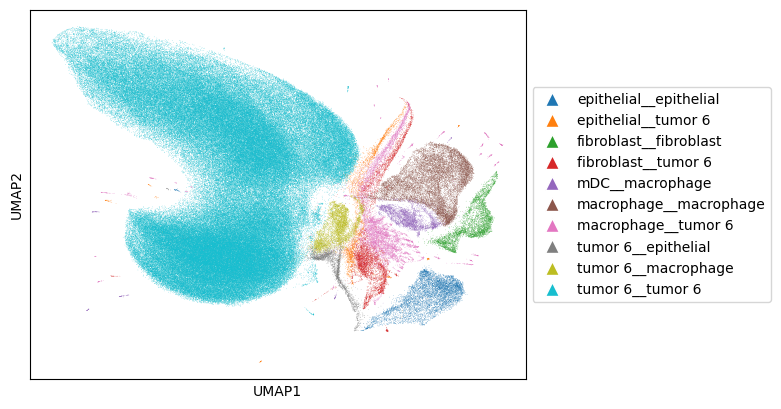

In [9]:
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plotx(adata, marker="^"):
    # Generate the UMAP plot with smaller points (e.g., size=10)
    sc.pl.umap(adata, color='cell_type', title="", show=False, save=False, size=0.05)

    # Access the current figure and axis
    fig = plt.gcf()
    ax = plt.gca()

    # Get the scatter plot and update the marker style
    for artist in ax.collections:
        artist.set_paths([plt.matplotlib.markers.MarkerStyle(marker).get_path()])
        artist.set_offsets(artist.get_offsets())  # Force redraw of the updated markers

    # Modify the legend markers to match the plot markers and move the legend to the right
    handles, labels = ax.get_legend_handles_labels()
    new_handles = [Line2D([0], [0], marker=marker, color='w', markerfacecolor=h.get_facecolor()[0], markersize=10) for h in handles]
    
    ax.legend(handles=new_handles, labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))

    # Show the plot (optional)
    plt.show()

    # Save the plot with the desired filename
    fig.savefig("./figures/CCI_UMAP.pdf", bbox_inches='tight')

# Example call to the function
plotx(adatax)

In [6]:
unique=np.unique(adata.obs['cell_type'],return_counts=True)
unique_arg=np.argsort(-unique[1])
print(unique[0][unique_arg].tolist(),unique[1][unique_arg].tolist())

['tumor 6__tumor 6', 'macrophage__macrophage', 'macrophage__tumor 6', 'epithelial__epithelial', 'fibroblast__tumor 6', 'tumor 6__macrophage', 'fibroblast__fibroblast', 'mDC__macrophage', 'tumor 6__epithelial', 'epithelial__tumor 6', 'epithelial__macrophage', 'tumor 6__fibroblast', 'tumor 12__tumor 6', 'endothelial__endothelial', 'macrophage__epithelial', 'endothelial__tumor 6', 'fibroblast__endothelial', 'epithelial__endothelial', 'endothelial__fibroblast', 'endothelial__epithelial', 'epithelial__fibroblast', 'neutrophil__tumor 6', 'fibroblast__macrophage', 'fibroblast__epithelial', 'tumor 6__endothelial', 'macrophage__fibroblast', 'macrophage__endothelial', 'tumor 6__tumor 12', 'macrophage__mDC', 'T CD4 memory__fibroblast', 'monocyte__macrophage', 'endothelial__macrophage', 'T CD8 memory__macrophage', 'tumor 13__tumor 6', 'tumor 6__neutrophil', 'macrophage__T CD8 memory', 'T CD8 memory__tumor 6', 'tumor 9__tumor 6', 'T CD4 memory__tumor 6', 'fibroblast__T CD4 memory', 'T CD4 memory__e

In [7]:
desired_CCC_type='fibroblast__tumors'#'tumors__fibroblast'#'fibroblast__tumors'#'Micro__Endo'#'Astro__Oligo'#'OPC__L2/3 IT'#'Micro__L4/5 IT'#'OPC__L4/5 IT'#'Micro__L4/5 IT','Micro__L6 CT'

def get_type_adata(adata,cell_type_pair):
    flag1=[i==cell_type_pair.split("__")[1] for i in adata.obs['cell_type_target']]
    adata_type=adata[flag1]
    
    flag2=[i==cell_type_pair for i in adata_type.obs['cell_type']]
    adata_type.obs["is_target_interaction"]=flag2
    adata_type.obs["is_target_interaction_str"]=[str(i) for i in flag2]
    print(np.sum(flag2),adata_type.shape[0])
    return adata_type

adata_type=get_type_adata(adata,desired_CCC_type)

0.0 0


/tmp/ipykernel_4026304/3216381252.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_type.obs["is_target_interaction"]=flag2
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [8]:
def cluster_and_plot(adata_original,desired_CCC_type):
    adata=adata_original[adata_original.obs["is_target_interaction"]==True]
    sc.pp.scale(adata)
    # PCA
    sc.tl.pca(adata)
    # Neighborhood Graph
    sc.pp.neighbors(adata)
    # Clustering
    sc.tl.leiden(adata,resolution=0.05)  # or sc.tl.louvain(adata)
    # Visualization
    sc.tl.umap(adata,min_dist=0.1)
    sc.pl.umap(adata, color='leiden',title="Cluster of "+desired_CCC_type+" cell type interaction")
    sc.pl.umap(adata, color='distance',title="Distance of "+desired_CCC_type+" cell type interaction")
    return np.array(adata.obs['leiden'].values)
leiden=cluster_and_plot(adata_type[adata_type.obs["is_target_interaction"]],desired_CCC_type)

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
def merge_group(adata_type,groups):
    groups1=[]
    cnt=0
    for i in range(len(adata_type.obs["is_target_interaction"])):
        if adata_type.obs["is_target_interaction"][i]==False:
            groups1.append("-1")
        else:
            groups1.append(groups[cnt])
            cnt=cnt+1
    assert cnt==len(groups)
    adata_type.obs["group"]=groups1
    return adata_type

adata_type=merge_group(adata_type,leiden)
print(adata_type)

In [ ]:
def spatial_visualize_type(adata,interaction_name):
    sc.set_figure_params(figsize=(8, 8))  # Adjust figure size as needed
    sc.pl.scatter(
        adata,
        x='to_position_x',#'position_x',
        y='to_position_y',#'position_y',
        color="is_target_interaction",
        title=f"Spatial cluster of {interaction_name} interaction"
    )
    
    adata1=adata[adata.obs["is_target_interaction"]]
    sc.set_figure_params(figsize=(8, 8))  # Adjust figure size as needed
    sc.pl.scatter(
        adata1,
        x='to_position_x',#'position_x',
        y='to_position_y',#'position_y',
        color='group',
        title=f"Spatial cluster of {interaction_name} interaction"
    )
spatial_visualize_type(adata_type,desired_CCC_type)

In [ ]:
def filter_same_target_cell(adata_type):
    unique_y=[]
    group_y=[]
    
    useful_index=[]
    
    for i in range(adata_type.shape[0]):
        if len(unique_y)==0:
            unique_y.append(adata_type.obsm["y"][i,:])
            group_y.append(adata_type.obs["group"][i])
            useful_index.append(i)
            continue
        if np.sum(adata_type.obsm["y"][i,:]-unique_y[-1])==0:
            groupi=adata_type.obs["group"][i]
            if int(groupi)>int(group_y[-1]):
                group_y[-1]=groupi
                useful_index[-1]=i
            continue
        unique_y.append(adata_type.obsm["y"][i,:])
        group_y.append(adata_type.obs["group"][i])
        useful_index.append(i)
    
    adata_new=adata_type[np.array(useful_index)]
    adata_new.obs["group"]=group_y
    return adata_new        

adata_type1=filter_same_target_cell(adata_type)
print(adata_type,adata_type1)

In [ ]:
def spatial_visualize_type1(adata1,interaction_name):
    adata=adata1[adata1.obs["group"].isin(["0","1"])]
    sc.set_figure_params(figsize=(8, 8))  # Adjust figure size as needed
    sc.pl.scatter(
        adata,
        x='to_position_x',#'position_x',
        y='to_position_y',#'position_y',
        color="group",
        title=f"Spatial cluster of {interaction_name} interaction"
    )
    sc.pl.scatter(
        adata,
        x='from_position_x',#'position_x',
        y='from_position_y',#'position_y',
        color="group",
        title=f"Spatial cluster of {interaction_name} interaction"
    )
spatial_visualize_type1(adata_type1,desired_CCC_type)

In [ ]:
import anndata as ad
import matplotlib.pyplot as plt

def spatial_visualize_type2(adata, adata_all, interaction_name):
    adata1=adata[adata.obs["group"].isin(["0","1"])]
    
    # Modify 'group' in adata based on interaction_name
    interaction_suffix = interaction_name.split("__")[1]
    adata1.obs['cell_type_target'] = adata1.obs['group'].apply(lambda x: interaction_suffix + "_" + x)

    adata2=sc.concat([adata_all[::5,:],adata1],axis=0)
    adata2=adata2[adata2.obs['cell_type_target']!=interaction_suffix]
    print(adata2)
    # Plot for adata1
    sc.pl.scatter(
        adata2,
        x='to_position_x',
        y='to_position_y',
        color='cell_type_target',  # Use the new 'modified_group' for coloring
        title=f"Spatial cluster of {interaction_name} interaction",
        size=4
    )

spatial_visualize_type2(adata_type1,adata,desired_CCC_type)

In [ ]:
import anndata as ad

def filter_extreme_percentiles(adata, select, percentile_low=5, percentile_high=95):
    # Extracting and flattening the list of gene tuples
    gene_tuples = adata.uns['rank_genes_groups']['names'][:select]
    gene_names = [gene for tup in gene_tuples for gene in tup]  # Flatten the list of tuples into a list of gene names
    print(adata.uns['rank_genes_groups']['names'][:select],gene_names)
    # Remove duplicates if necessary
    gene_names = list(set(gene_names))

    # Data structure to keep track of which indices to keep
    indices_to_keep = set(range(adata.shape[0]))

    # Iterate over each gene, filter rows based on the percentiles
    for gene in gene_names:
        if gene in adata.var_names:
            # Calculate the low and high percentile values
            values = adata.obs_vector(gene)  # Get a numpy array of the values for this gene
            low_threshold = np.percentile(values, percentile_low)
            high_threshold = np.percentile(values, percentile_high)

            # Determine indices that fall outside the low and high thresholds
            filtered_indices = np.where((values >= low_threshold) & (values <= high_threshold))[0]
            indices_to_keep.intersection_update(filtered_indices)
        else:
            print(f"Gene {gene} not found in the variable names.")

    # Filter the adata to keep only the desired rows
    adata = adata[list(indices_to_keep), :]

    return adata

genes = torch.load("/".join(data_dir.split("/")[:-2]) + "/genes.pth")

In [ ]:
select=10

adata_type_attention=ad.AnnData(X=np.abs(adata_type1.obsm["attention_score"]), obs=adata_type1.obs)
adata_type_attention=adata_type_attention[adata_type_attention.obs["group"].isin(["0","1"])]#,"2","2","3"
adata_type_attention.var_names=genes
sc.tl.rank_genes_groups(adata_type_attention, 'group', method='t-test_overestim_var')#sc.tl.rank_genes_groups(adata_type_attention, 'group', method='t-test')
adata_type_attention=filter_extreme_percentiles(adata_type_attention,select)
sc.pl.rank_genes_groups_heatmap(adata_type_attention, n_genes=select, show_gene_labels=True,standard_scale='var', cmap='viridis')
print(adata_type_attention)

adata_type_y=ad.AnnData(X=adata_type1.obsm["y"], obs=adata_type1.obs)
adata_type_y=adata_type_y[adata_type_y.obs["group"].isin(["1","0"])]#,"2","3"
adata_type_y.var_names=genes
sc.tl.rank_genes_groups(adata_type_y, 'group', method='t-test_overestim_var')
adata_type_y.uns['rank_genes_groups']=adata_type_attention.uns['rank_genes_groups']
adata_type_y=filter_extreme_percentiles(adata_type_y,select)
sc.pl.rank_genes_groups_heatmap(adata_type_y, n_genes=select, show_gene_labels=True,standard_scale='var', cmap='viridis')

sc.tl.rank_genes_groups(adata_type_y, 'group', method='t-test_overestim_var')
adata_type_y=filter_extreme_percentiles(adata_type_y,select)
sc.pl.rank_genes_groups_heatmap(adata_type_y, n_genes=select, show_gene_labels=True,standard_scale='var', cmap='viridis')

In [ ]:
print(genes)

def extract_genes_and_pvals_by_group(adata, group_index, cutoff=0.05, up=True, name=None):
    # Extracting gene names and p-values from the adata object
    gene_names = adata.uns['rank_genes_groups']['names']
    p_values = adata.uns['rank_genes_groups']['pvals_adj']
    logfoldchanges=adata.uns['rank_genes_groups']['logfoldchanges']
    p_adj=adata.uns['rank_genes_groups']['pvals_adj']
    
    # Lists to hold filtered gene names and their corresponding p-values
    filtered_genes = []
    filtered_pvals = []
    
    # Iterate through each group in the gene names and p-values
    for gene_group, pval_group,fold_group in zip(gene_names, p_values,logfoldchanges):
        gene = gene_group[group_index]
        pval = pval_group[group_index]
        foldchange=fold_group[group_index]
        
        # Check if p-value is below the cutoff and add to the lists if it is
        #print(pval,foldchange)
        if pval < cutoff and ((foldchange>0)==up):
            filtered_genes.append(gene)
            filtered_pvals.append(pval)
    
    return filtered_genes, filtered_pvals

sig_genes1,p_val1=extract_genes_and_pvals_by_group(adata_type_y,1,0.05,False)
print(sig_genes1,len(sig_genes1))

sig_genes0,p_val0=extract_genes_and_pvals_by_group(adata_type_y,0,0.05,False)
print(sig_genes0,len(sig_genes0))
'''
sig_genes2,p_val2=extract_genes_and_pvals_by_group(adata_type_attention,0)
print(sig_genes2)

print(np.sum([x in sig_genes2 for x in sig_genes1])/len(sig_genes1))
print([x in sig_genes2 for x in sig_genes1])
'''

In [ ]:
import pandas as pd
def compute_log_fold_change(adata, name):
    # Check if 'group' is in adata.obs
    if 'group' not in adata.obs.columns:
        raise ValueError("The adata object must contain 'group' in adata.obs")

    # Get unique groups
    groups = list(sorted(adata.obs['group'].unique()))
    print(groups)
    if len(groups) != 2:
        raise ValueError("There must be exactly two groups in 'adata.obs['group']'")

    # Calculate mean expression for each group
    means = {}
    for group in groups:
        subset = adata[adata.obs['group'] == group]
        means[group] = np.mean(subset.X, axis=0)
    
    # Calculate log-fold change
    log_fold_change = np.log(means[groups[1]] / means[groups[0]])

    # Convert log_fold_change to a pandas DataFrame
    gene_names = adata.var_names
    log_fold_change_df = pd.DataFrame(log_fold_change, index=gene_names, columns=['log_fold_change'])

    # Save to CSV
    name1=name.replace("/","-")
    log_fold_change_df.to_csv(f"./DEG/{name1}.csv")

    print(f"Log-fold change written to {name}.csv")

compute_log_fold_change(adata_type_y, desired_CCC_type)